# Setup

## Install and import libraries

In [ ]:
!pip install geopandas
!pip install networkx

In [ ]:

from google.cloud import bigquery
from pyproj import CRS

import geopandas as gpd
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import shapely
import shapely.geometry
from shapely import wkt
from shapely.geometry import Point
from shapely.ops import nearest_points, snap


client = bigquery.Client()



# Helper functions

## Reproject BQ GIS to CRS

In [ ]:
def project_to_crs(df):
  crs = CRS.from_dict(
  {"proj": "utm", "zone": 31, "north": "true"}).to_authority()
  df = df.to_crs(crs)
  return df

## Create Geodataframe from Pandas dataframe

In [ ]:
def create_gdf(df):
  df['geometry'] = df['geometry'].apply(wkt.loads)
  geo_df = gpd.GeoDataFrame(df, geometry='geometry')
  geo_df = geo_df.set_crs("epsg:3857")
  geo_df = project_to_crs(geo_df)
  return geo_df


# BigQuery: Prepare and pull data

In [ ]:
bpd.options.bigquery.project = "scg-demo-dev"
bpd.options.bigquery.location = "us-central1"

gdf_sql = '''
    with RoadSegments AS(
    SELECT
      * EXCEPT(geometry),
      ST_SNAPTOGRID(geometry, 0.000001) AS geometry,
      ST_LENGTH(geometry) AS length
    FROM
      `scg-demo-dev.warehouse_floorplan.combined_layout`)

  SELECT * FROM RoadSegments
'''
df = client.query_and_wait(gdf_sql).to_dataframe()

geo_df = create_gdf(df)
geo_df.head()


,id,inventory_category_one,inventory_category_two,geometry,length
0,AISLE_2,None,None,"LINESTRING (166021.443 0.001, 166021.443 0.001...",111.244505
1,GRID_H8,None,None,"LINESTRING (166021.444 0, 166021.444 0)",11.119510
2,AISLE_9,None,None,"LINESTRING (166021.443 0, 166021.443 0, 166021...",111.244515
3,AISLE_10,None,None,"LINESTRING (166021.443 0, 166021.443 0, 166021...",111.196145
4,AISLE_J,None,None,"LINESTRING (166021.444 0.001, 166021.444 0.001...",111.198620


# Build Graph

In [ ]:
# Build the graph from the snapped GeoDataFrame
# G.clear()
G = nx.Graph()
for index, row in geo_df.iterrows():

    line = row['geometry']
    length = row['length']
    id = row['id']
    coords = list(line.coords)
    inventory_one = row['inventory_category_one']
    inventory_two = row['inventory_category_two']
    # start_id=f"{row['id']}_start"
    # end_id=f"{row['id']}_end"
    for i in range(len(coords) - 1):
        u = coords[i]
        # G.add_node(u)
        v = coords[i + 1]
        # G.add_node(v, id=end_id)
        G.add_edge(u, v, id=id, length=line.length, inventory_one = inventory_one, inventory_two=inventory_two )

nx.is_connected(G)

True

## Plot floorplan graph

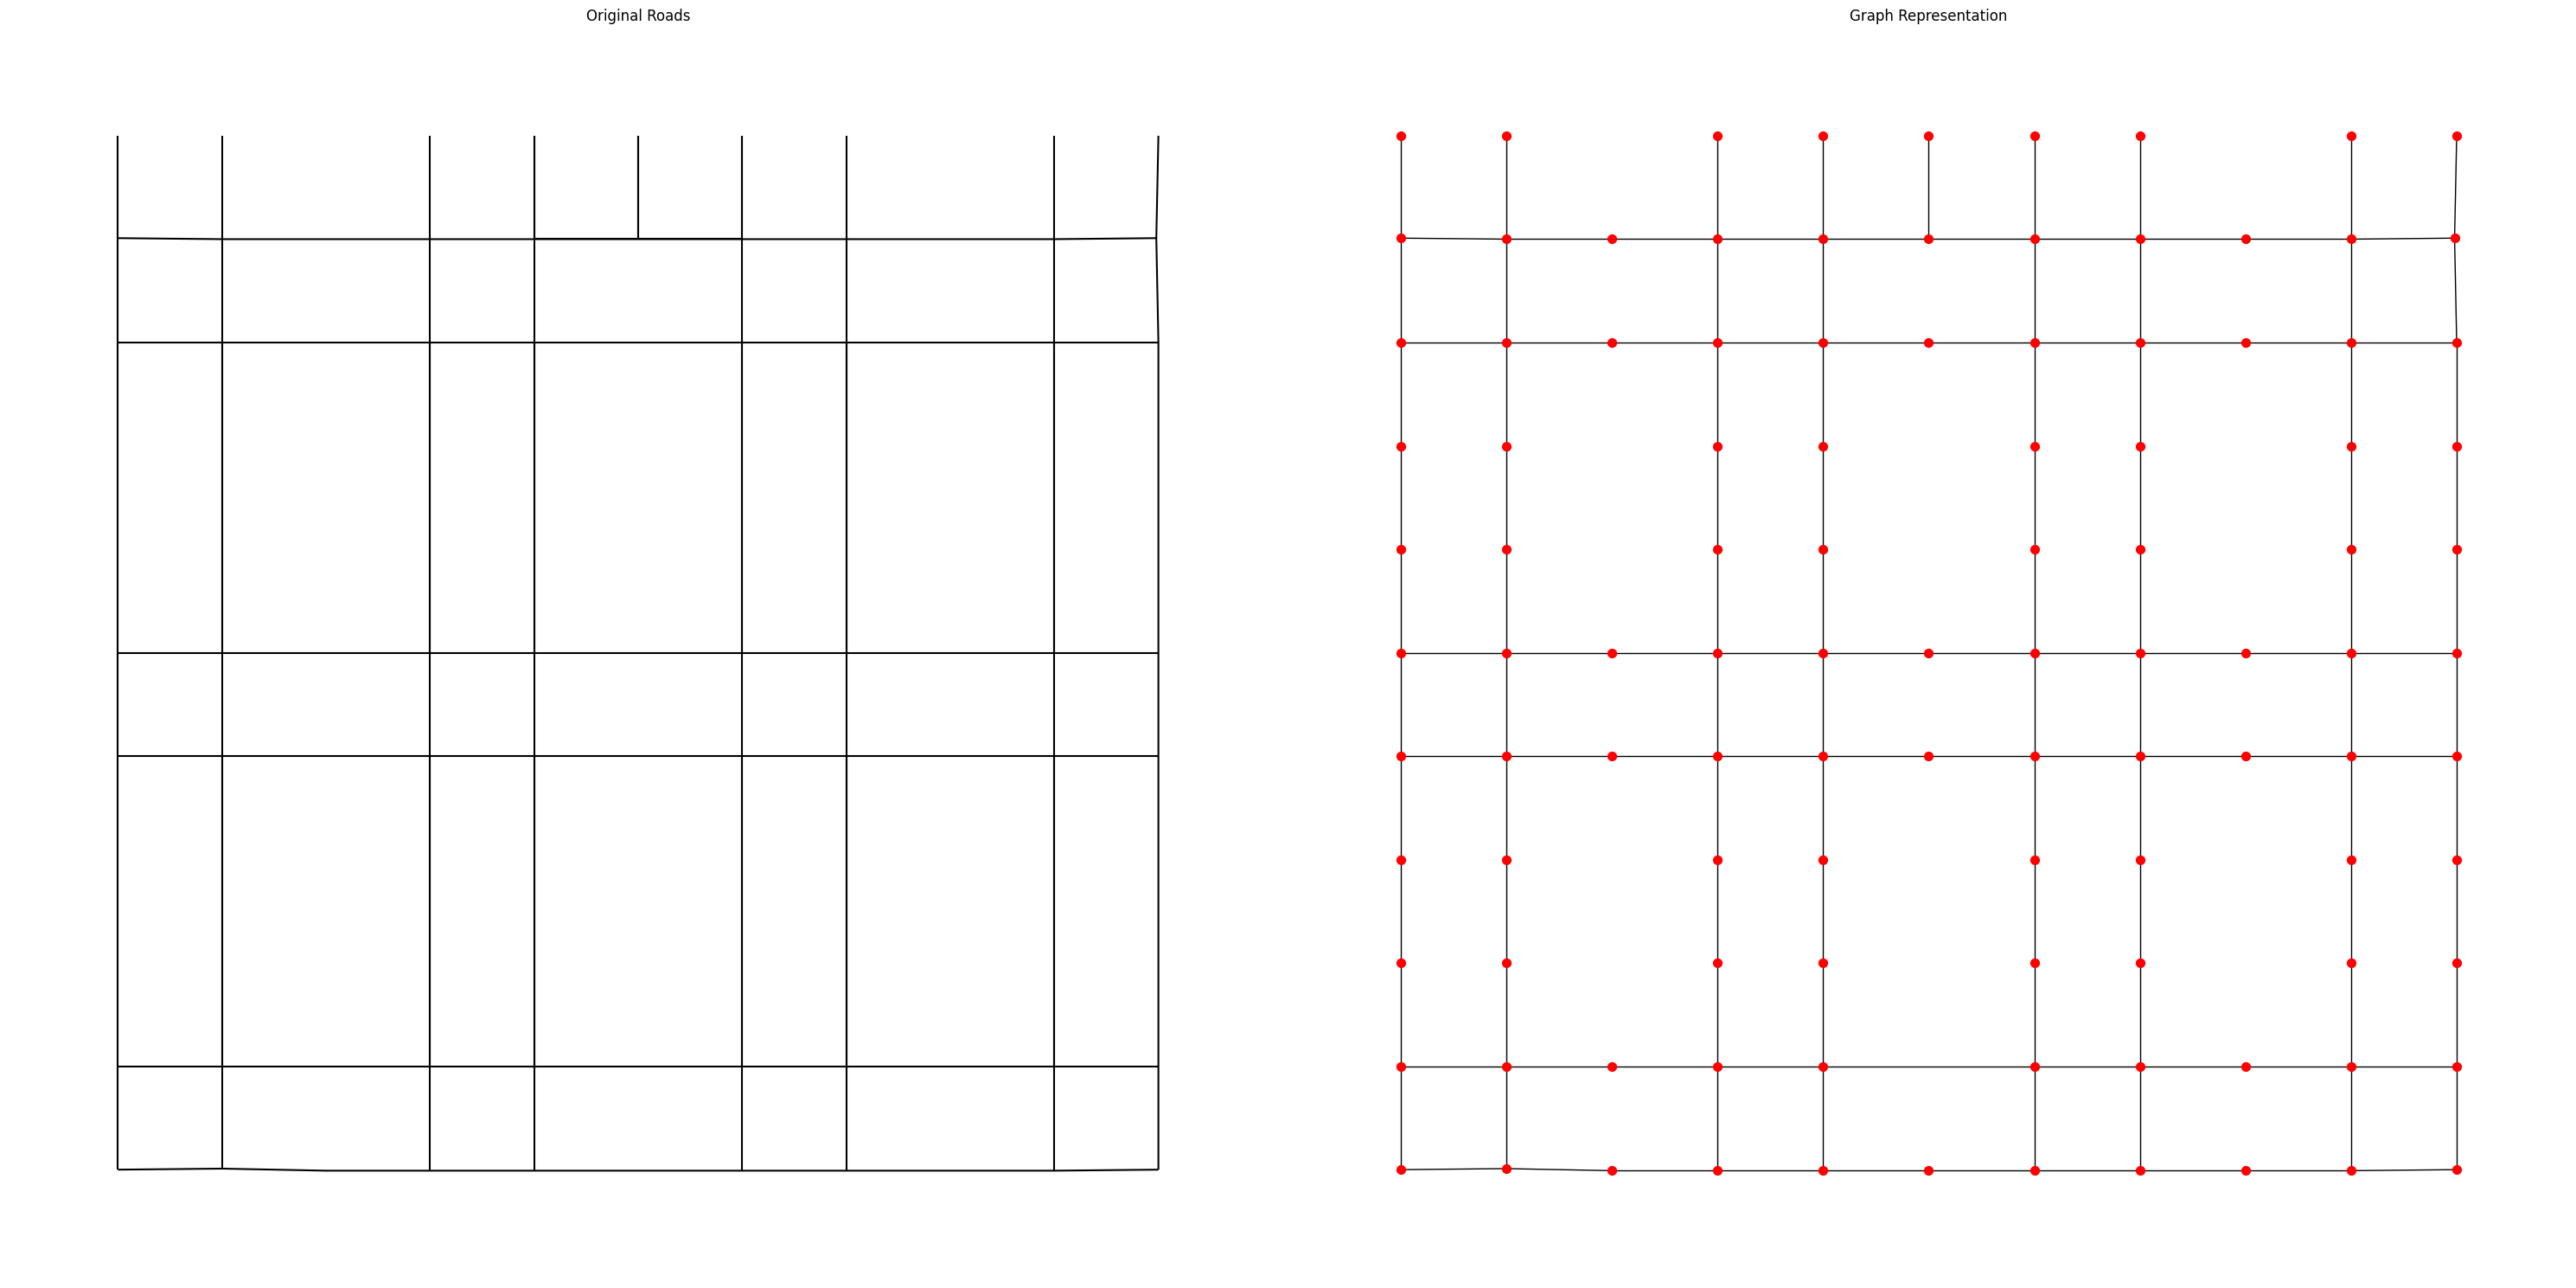

In [ ]:
# Plotting
for (n1, n2, d) in G.edges(data=True):
    if 'geometry' in d:
        del d['geometry'] # No 'geometry' attribute added now, so this is not necessary

f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)

# Plot the original GeoDataFrame
geo_df.plot(color="k", ax=ax[0])
ax[0].set_title("Original Roads")
ax[0].axis("off")

# Plot the graph
pos = dict(zip(G.nodes, G.nodes)) # Position nodes based on their coordinates
nx.draw(G, pos, ax=ax[1], with_labels=False, node_size=50, node_color="red") # Adjust node size and color for better visualization
ax[1].set_title("Graph Representation")
ax[1].axis("off")


plt.tight_layout() # to prevent labels from getting cut off
plt.show()

#Plan a route

In [46]:
item_one_node = "GRID_I7" # @param {"type":"string","placeholder":"GRID_I7"}
item_two_node = "GRID_B3" # @param {"type":"string","placeholder":"GRID_B3"}
start_node = "START_POINT"
end_node = "END_POINT"

df_search = geo_df.copy()

start_node_edge = df_search.query('id == @start_node')['geometry'].get_coordinates().iloc[0]
item_one_node_node_edge = df_search.query('id == @item_one_node')['geometry'].get_coordinates()
item_two_node_edge = df_search.query('id == @item_two_node')['geometry'].get_coordinates()
end_node_edge = df_search.query('id == @end_node')['geometry'].get_coordinates()

start_node_edge = start_node_edge
item_one_edge = item_one_node_node_edge.iloc[0]
item_two_edge = item_two_node_edge.iloc[0]
end_node_edge = end_node_edge.iloc[0]

start_node = (start_node_edge['x'], start_node_edge['y'])
item_one_node = (item_one_edge['x'], item_one_edge['y'])
item_two_node = (item_two_edge['x'], item_two_edge['y'])
end_node = (end_node_edge['x'], end_node_edge['y'])


## Compute distances

In [51]:

# print(df_search.head())




# print(all_nodes)

all_routes = {}
route1 = {"start": start_node, "first_item": item_one_node, "second_item": item_two_node, "end": end_node}
all_routes['route1'] = route1
route2 = {"start": start_node, "first_item": item_two_node, "second_item": item_one_node, "end": end_node}
all_routes['route2'] = route2
route_two = nx.shortest_path_length(G, start_node, item_two_node, weight='length') + nx.shortest_path_length(G, item_two_node, item_one_node, weight='length') + nx.shortest_path_length(G, item_two_node, end_node, weight='length')

def find_shortest_routes(all_routes):
  route_len = {}
  for index in all_routes:
    print(index)
    route = all_routes[f"{index}"]
    route_len[f"{index}"] = nx.shortest_path_length(G, route['start'], route['first_item'], weight='length') + nx.shortest_path_length(G, route['first_item'], route['second_item'], weight='length') + nx.shortest_path_length(G, route['second_item'], route['end'], weight='length')
  shortest_route = min(route_len, key=route_len.get)
  route_path = all_routes[shortest_route]
  shortest_path_nodes_one = nx.shortest_path(G, source=route_path['start'], target=route_path['first_item'])
  shortest_path_nodes_two = nx.shortest_path(G, source=route_path['first_item'], target=route_path['second_item'])
  shortest_path_nodes_three = nx.shortest_path(G, source=route_path['second_item'], target=route_path['end'])
  shortest_path_nodes = shortest_path_nodes_one + shortest_path_nodes_two + shortest_path_nodes_three
  shortest_path_edges_one = list(zip(shortest_path_nodes_one,shortest_path_nodes_one[1:]))
  shortest_path_edges_two = list(zip(shortest_path_nodes_two,shortest_path_nodes_two[1:]))
  shortest_path_edges_three = list(zip(shortest_path_nodes_three,shortest_path_nodes_three[1:]))
  print(f"Shortest path is: 1) Start Node, 2) {route_path['first_item']}, 3){route_path['second_item']}, 4) End Node")
  return(shortest_path_nodes, shortest_path_edges_one, shortest_path_edges_two, shortest_path_edges_three, route_path)

shortest_path_nodes, shortest_path_edges_one, shortest_path_edges_two, shortest_path_edges_three, route_path = find_shortest_routes(all_routes)


route1
route2
Shortest path is: 1) Start Node, 2) (166021.4431806386, 0.0007954240911345467), 3)(166021.4439814235, 0.00039771204556464135), 4) End Node


## Visualize route



*   Red line: Path from start point to first item (where boxes are stored)
*   Green line: Path from first item to second item
*   Blue line: Path from second item to end point (where trucks are loaded)



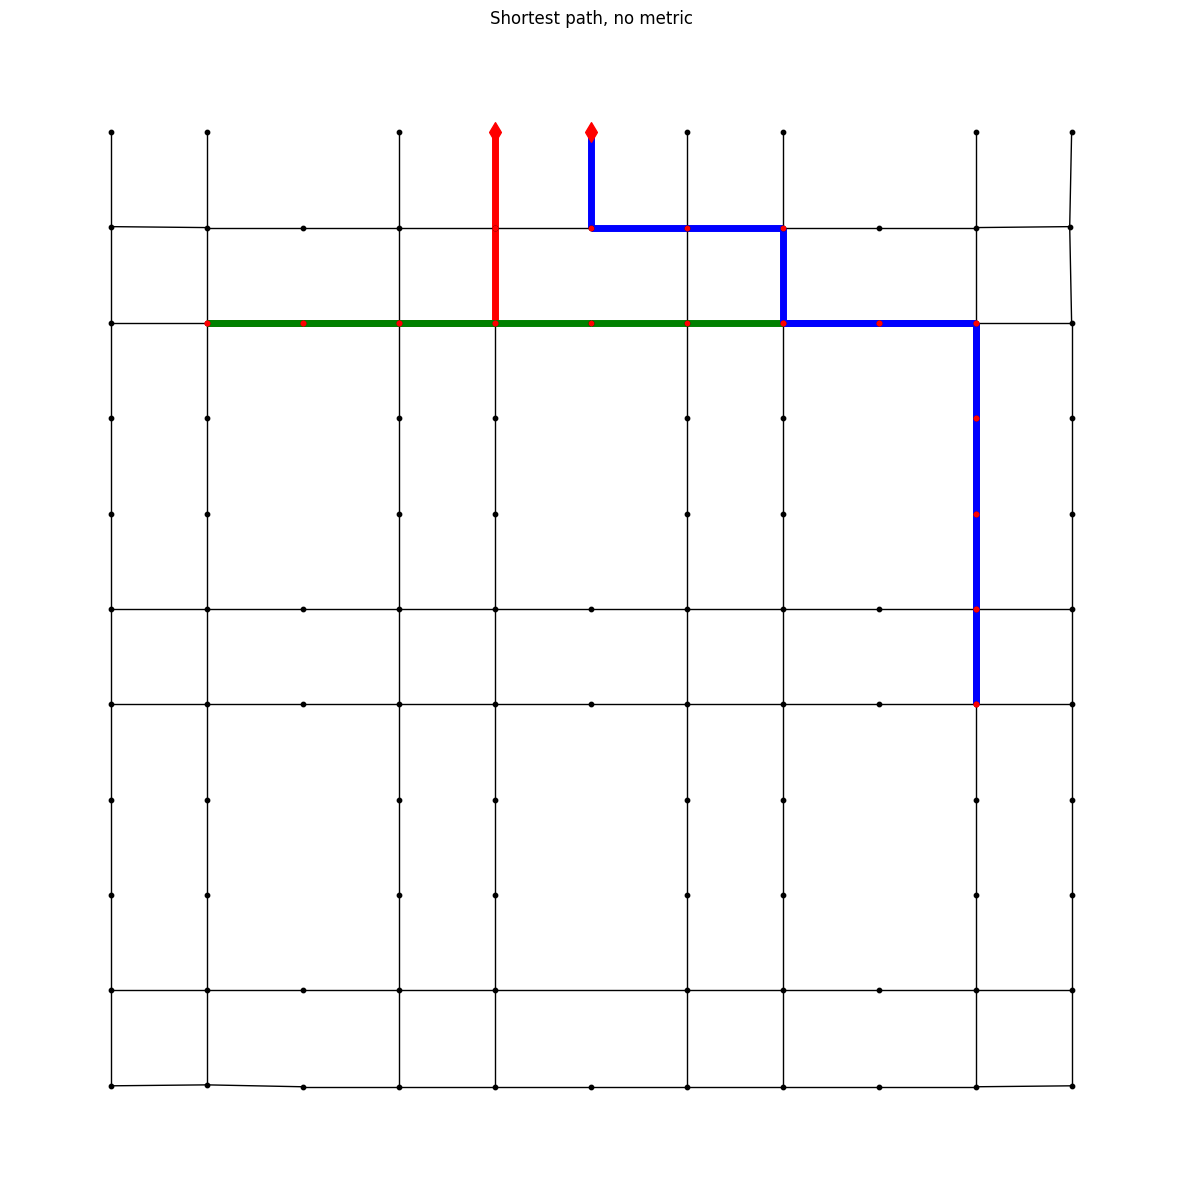

In [52]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.set_title("Shortest path, no metric")
positions = dict(zip(G.nodes, G.nodes)) # Position nodes based on their coordinates

nx.draw(G,positions,node_color='k', node_size=10)

nx.draw_networkx_nodes(G,positions, nodelist=shortest_path_nodes, node_color='r', node_size=10)
nx.draw_networkx_nodes(G,positions, nodelist=[start_node, end_node], node_color='r', node_size=100, node_shape='d')
nx.draw_networkx_edges(G,positions,edgelist=shortest_path_edges_one,edge_color='r',width=5)
nx.draw_networkx_edges(G,positions,edgelist=shortest_path_edges_two,edge_color='g',width=5)
nx.draw_networkx_edges(G,positions,edgelist=shortest_path_edges_three,edge_color='b',width=5)

plt.show()